In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from google.colab import files

In [2]:
uploaded = files.upload()

Saving data-2021.csv to data-2021.csv
Saving data.csv to data.csv
Saving log-2021.csv to log-2021.csv
Saving log.csv to log.csv


In [3]:
# get the paths of original datasets
data_path = '/content/data.csv'
log_path = '/content/log.csv'
data_path_2021 = '/content/data-2021.csv'
log_path_2021 = '/content/log-2021.csv'

# load data
data_df = pd.read_csv(data_path)
log_df = pd.read_csv(log_path)
data_df_2021 = pd.read_csv(data_path_2021)
log_df_2021 = pd.read_csv(log_path_2021)

# rename the student in 2021
data_df_2021['Student'] = data_df_2021['Student'] + '-2021'
log_df_2021['Student'] = log_df_2021['Student'] + '-2021'

# merge data
data_df = pd.concat([data_df, data_df_2021])
log_df = pd.concat([log_df, log_df_2021])

columns_with_missing_values = ['Week 3 quiz', 'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz',
       'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz', 'Week 10 quiz',
       'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
       'Week 15 quiz', 'Week 16 quiz', 'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
       'Week 7 homework', 'Week 8 homework', 'Week 9 homework',
       'Week 10 homework', 'Week 11 homework', 'Week 13 homework',
       'Week 14 homework', 'Week 15 homework']
columns_not_missing_values = ['Week 1 quiz', 'Week 2 quiz',
       'Week 3 quiz', 'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz',
       'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz', 'Week 10 quiz',
       'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
       'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework', 'Week 2 homework',
       'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
       'Week 7 homework', 'Week 8 homework', 'Week 9 homework',
       'Week 10 homework', 'Week 11 homework', 'Week 13 homework',
       'Week 14 homework', 'Week 15 homework']

columns_name_student = "Student"
columns_name_score = "Score"
columns_name_grade = "Grade"

columns_name_activity = "Activity"
columns_name_day = "Day"
columns_name_time = "Time"
add_column_activity_weeknumber = "Activity_Num"
add_column_activity_score = "Activity Score"

In [5]:
# in data_df, subsititute - with NaN in column score
data_df[columns_name_score] = data_df[columns_name_score].replace('-', np.nan)
data_df[columns_name_score] = pd.to_numeric(data_df[columns_name_score], errors='coerce')

# in data_df, delete the data that does not participate in any activity or got F due to other activtiy
# in data_df, delete the data that got A due to pre-exam
data_df = data_df.dropna(subset=[columns_name_score])
data_df = data_df.drop(data_df[(data_df[columns_name_score] > 50) & (data_df[columns_name_grade] == 'F')].index)

conditions = (data_df[columns_with_missing_values].eq(0).all(axis=1)) & (data_df[columns_name_grade] == 'A')
data_df = data_df[~conditions]

# in log_df, delete the data after ddl
log_df[columns_name_time] = pd.to_datetime(log_df[columns_name_time])
log_df[add_column_activity_weeknumber] = log_df[columns_name_activity].str.extract(r"(\d+)")
log_df[add_column_activity_weeknumber] = log_df[add_column_activity_weeknumber].fillna(0)
log_df[add_column_activity_weeknumber] = log_df[add_column_activity_weeknumber].astype(int)

week1 = (log_df[add_column_activity_weeknumber] == 1)
week2_16 = (log_df[add_column_activity_weeknumber] > 1) & (log_df[add_column_activity_weeknumber] <= 16)

time_start_for_week2_16 = (log_df[columns_name_time].dt.time < pd.to_datetime('18:00:00').time())
time_end_for_week2_16 = (log_df[columns_name_time].dt.time > pd.to_datetime('8:00:00').time())

invalid_for_week1 = (log_df[columns_name_day] < 1) | (log_df[columns_name_day] > 7)

invalid_start_for_week2_16 = (log_df[columns_name_day] < (7 * (log_df[add_column_activity_weeknumber] -1) - 3)) | ((log_df[columns_name_day] == (7 * (log_df[add_column_activity_weeknumber] -1) - 3)) & time_start_for_week2_16)
invalid_end_for_week2_16 = (log_df[columns_name_day] > (7 * (log_df[add_column_activity_weeknumber] -1) + 4)) | ((log_df[columns_name_day] == (7 * (log_df[add_column_activity_weeknumber] -1) + 4)) & time_end_for_week2_16)

condition1 = week1 & invalid_for_week1
condition2 = week2_16 & (invalid_start_for_week2_16 | invalid_end_for_week2_16)

log_df = log_df.drop(log_df[condition1].index)
if not log_df.empty:
    log_df = log_df.drop(log_df[condition2].index)
log_df.reset_index(drop=True, inplace=True)

log_df = log_df.drop(add_column_activity_weeknumber, axis=1)

In [6]:
# in log_df, build new column Score_First and Score_Last for first score and last score respectively
suffixes_first = '_First'
suffixes_last = '_Last'
columns_name_first_score = columns_name_score + suffixes_first
columns_name_last_score = columns_name_score + suffixes_last
columns_name_first_day = columns_name_day + suffixes_first
columns_name_last_day = columns_name_day + suffixes_last
columns_name_first_time = columns_name_time + suffixes_first
columns_name_last_time = columns_name_time + suffixes_last

log_df[columns_name_day] = log_df[columns_name_day].astype(int)
log_df_sorted = log_df.sort_values([columns_name_student, columns_name_activity, columns_name_day, columns_name_time])

first_scores = log_df_sorted.groupby([columns_name_student, columns_name_activity]).first()
last_scores = log_df_sorted.groupby([columns_name_student, columns_name_activity]).last()

log_df = pd.merge(log_df, first_scores, on=[columns_name_student, columns_name_activity], suffixes=('', suffixes_first))
log_df = pd.merge(log_df, last_scores, on=[columns_name_student, columns_name_activity], suffixes=('', suffixes_last))

log_df = log_df.drop(columns_name_day, axis=1)
log_df = log_df.drop(columns_name_time, axis=1)
log_df = log_df.drop(columns_name_first_day, axis=1)
log_df = log_df.drop(columns_name_last_day, axis=1)
log_df = log_df.drop(columns_name_first_time, axis=1)
log_df = log_df.drop(columns_name_last_time, axis=1)

In [7]:
# in log_df, detele all the data without maximum score
max_score_df = log_df.groupby([columns_name_student, columns_name_activity, columns_name_first_score, columns_name_last_score])[columns_name_score].max().reset_index()
log_df = log_df.merge(max_score_df, on=[columns_name_student, columns_name_activity, columns_name_first_score, columns_name_last_score, columns_name_score], how='inner')
log_df.drop_duplicates(subset=[columns_name_student, columns_name_activity, columns_name_first_score, columns_name_last_score], keep='first', inplace=True)

In [8]:
# merge data and log based on student and activity
# Pivot log_df to get the columns for max score, first score, and last score
max_score_df = log_df.pivot(index='Student', columns='Activity', values='Score').add_suffix('_maxscore')
first_score_df = log_df.pivot(index='Student', columns='Activity', values='Score_First').add_suffix('_firstscore')
last_score_df = log_df.pivot(index='Student', columns='Activity', values='Score_Last').add_suffix('_lastscore')

# Merge the pivoted DataFrames with data_df
merged_df = data_df.merge(max_score_df, left_on='Student', right_index=True, how='left')
merged_df = merged_df.merge(first_score_df, left_on='Student', right_index=True, how='left')
merged_df = merged_df.merge(last_score_df, left_on='Student', right_index=True, how='left')

In [9]:
data_df.to_csv('/content/data_df.csv', index=False)
files.download('/content/data_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
log_df.to_csv('/content/log_df.csv', index=False)
files.download('/content/log_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
merged_df.to_csv('/content/merged_df.csv', index=False)
files.download('/content/merged_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
from sklearn.model_selection import train_test_split

# define three sets of features
# first set: the number of attempts and maximum score of each exercise
features = ['Week 1 quiz', 'Week 2 quiz', 'Week 3 quiz',
            'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz', 'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz',
            'Week 10 quiz', 'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
            'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework', 'Week 2 homework',
            'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
            'Week 7 homework', 'Week 8 homework', 'Week 9 homework', 'Week 10 homework', 'Week 11 homework',
            'Week 13 homework', 'Week 14 homework', 'Week 15 homework', 'Week 1 homework_maxscore',
            'Week 1 quiz_maxscore', 'Week 10 homework_maxscore', 'Week 10 quiz_maxscore', 'Week 11 homework_maxscore',
            'Week 11 quiz_maxscore', 'Week 12 quiz_maxscore', 'Week 13 homework_maxscore', 'Week 13 quiz_maxscore',
            'Week 14 homework_maxscore', 'Week 14 quiz_maxscore', 'Week 15 homework_maxscore', 'Week 15 quiz_maxscore',
            'Week 16 quiz_maxscore', 'Week 2 homework_maxscore', 'Week 2 quiz_maxscore', 'Week 3 homework_maxscore',
            'Week 3 quiz_maxscore', 'Week 4 homework_maxscore', 'Week 4 quiz_maxscore', 'Week 5 homework_maxscore',
            'Week 5 quiz_maxscore', 'Week 6 quiz_maxscore', 'Week 7 homework_maxscore', 'Week 7 quiz_maxscore',
            'Week 8 homework_maxscore', 'Week 8 quiz_maxscore', 'Week 9 homework_maxscore', 'Week 9 quiz_maxscore']

# second set: maximum score of each exercise
features_new = ['Week 1 homework_maxscore',
            'Week 1 quiz_maxscore', 'Week 10 homework_maxscore', 'Week 10 quiz_maxscore', 'Week 11 homework_maxscore',
            'Week 11 quiz_maxscore', 'Week 12 quiz_maxscore', 'Week 13 homework_maxscore', 'Week 13 quiz_maxscore',
            'Week 14 homework_maxscore', 'Week 14 quiz_maxscore', 'Week 15 homework_maxscore', 'Week 15 quiz_maxscore',
            'Week 16 quiz_maxscore', 'Week 2 homework_maxscore', 'Week 2 quiz_maxscore', 'Week 3 homework_maxscore',
            'Week 3 quiz_maxscore', 'Week 4 homework_maxscore', 'Week 4 quiz_maxscore', 'Week 5 homework_maxscore',
            'Week 5 quiz_maxscore', 'Week 6 quiz_maxscore', 'Week 7 homework_maxscore', 'Week 7 quiz_maxscore',
            'Week 8 homework_maxscore', 'Week 8 quiz_maxscore', 'Week 9 homework_maxscore', 'Week 9 quiz_maxscore']

# third set: the number of attempts, first and last score of each exercise
features_third = ['Week 1 quiz', 'Week 2 quiz', 'Week 3 quiz',
            'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz', 'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz',
            'Week 10 quiz', 'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
            'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework', 'Week 2 homework',
            'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
            'Week 7 homework', 'Week 8 homework', 'Week 9 homework', 'Week 10 homework', 'Week 11 homework',
            'Week 13 homework', 'Week 14 homework', 'Week 15 homework', 'Week 1 homework_firstscore',
            'Week 1 quiz_firstscore', 'Week 10 homework_firstscore',
            'Week 10 quiz_firstscore', 'Week 11 homework_firstscore', 'Week 11 quiz_firstscore',
            'Week 12 quiz_firstscore', 'Week 13 homework_firstscore', 'Week 13 quiz_firstscore',
            'Week 14 homework_firstscore', 'Week 14 quiz_firstscore', 'Week 15 homework_firstscore',
            'Week 15 quiz_firstscore', 'Week 16 quiz_firstscore', 'Week 2 homework_firstscore',
            'Week 2 quiz_firstscore', 'Week 3 homework_firstscore', 'Week 3 quiz_firstscore',
            'Week 4 homework_firstscore', 'Week 4 quiz_firstscore', 'Week 5 homework_firstscore',
            'Week 5 quiz_firstscore', 'Week 6 quiz_firstscore', 'Week 7 homework_firstscore',
            'Week 7 quiz_firstscore', 'Week 8 homework_firstscore', 'Week 8 quiz_firstscore',
            'Week 9 homework_firstscore', 'Week 9 quiz_firstscore', 'Week 1 homework_lastscore',
            'Week 1 quiz_lastscore', 'Week 10 homework_lastscore', 'Week 10 quiz_lastscore',
            'Week 11 homework_lastscore', 'Week 11 quiz_lastscore', 'Week 12 quiz_lastscore',
            'Week 13 homework_lastscore', 'Week 13 quiz_lastscore', 'Week 14 homework_lastscore',
            'Week 14 quiz_lastscore', 'Week 15 homework_lastscore', 'Week 15 quiz_lastscore',
            'Week 16 quiz_lastscore', 'Week 2 homework_lastscore', 'Week 2 quiz_lastscore',
            'Week 3 homework_lastscore', 'Week 3 quiz_lastscore', 'Week 4 homework_lastscore',
            'Week 4 quiz_lastscore', 'Week 5 homework_lastscore', 'Week 5 quiz_lastscore',
            'Week 6 quiz_lastscore', 'Week 7 homework_lastscore', 'Week 7 quiz_lastscore',
            'Week 8 homework_lastscore', 'Week 8 quiz_lastscore', 'Week 9 homework_lastscore', 'Week 9 quiz_lastscore']

# define target：to predict the final course score
target = 'Score'

# dataset regularization
# split the data： 80%/20%
merged_df[features] = merged_df[features].fillna(value=0).replace('-', 0).astype(float)
merged_df[features_third] = merged_df[features_third].fillna(value=0).replace('-', 0).astype(float)
merged_df[columns_name_score] = merged_df[columns_name_score].fillna(value=0).replace('-', 0).astype(float)

train_df, test_df, train_labels, test_labels = train_test_split(merged_df[features],
                                                                merged_df[target],
                                                                test_size=0.2,
                                                                random_state=42)

train_df_new, test_df_new, train_labels_new, test_labels_new = train_test_split(merged_df[features_new],
                                                                merged_df[target],
                                                                test_size=0.2,
                                                                random_state=42)

train_df_third, test_df_third, train_labels_third, test_labels_third = train_test_split(merged_df[features_third],
                                                                merged_df[target],
                                                                test_size=0.2,
                                                                random_state=42)

In [31]:
# 保存为 CSV 文件
train_df_third.to_csv('test_df_third.csv', index=False)

# 下载文件
files.download('test_df_third.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# initical the models
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor()

# perform model training
linear_model.fit(train_df, train_labels)
tree_model.fit(train_df, train_labels)
forest_model.fit(train_df, train_labels)

# predictions on the test set
linear_predictions = linear_model.predict(test_df)
tree_predictions = tree_model.predict(test_df)
forest_predictions = forest_model.predict(test_df)

# second set of models
linear_model_new = LinearRegression()
tree_model_new = DecisionTreeRegressor()
forest_model_new = RandomForestRegressor()

linear_model_new.fit(train_df_new, train_labels_new)
tree_model_new.fit(train_df_new, train_labels_new)
forest_model_new.fit(train_df_new, train_labels_new)

linear_predictions_new = linear_model_new.predict(test_df_new)
tree_predictions_new = tree_model_new.predict(test_df_new)
forest_predictions_new = forest_model_new.predict(test_df_new)

# third set of models
linear_model_third = LinearRegression()
tree_model_third = DecisionTreeRegressor()
forest_model_third = RandomForestRegressor()

linear_model_third.fit(train_df_third, train_labels_third)
tree_model_third.fit(train_df_third, train_labels_third)
forest_model_third.fit(train_df_third, train_labels_third)

import pickle
# 保存模型
with open('forest_model_third.pkl', 'wb') as f:
    pickle.dump(forest_model_third, f)

from google.colab import files
files.download('forest_model_third.pkl')

linear_predictions_third = linear_model_third.predict(test_df_third)
tree_predictions_third = tree_model_third.predict(test_df_third)
forest_predictions_third = forest_model_third.predict(test_df_third)

# Compare the effect of each model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error
linear_mse = mean_squared_error(test_labels, linear_predictions)
tree_mse = mean_squared_error(test_labels, tree_predictions)
forest_mse = mean_squared_error(test_labels, forest_predictions)

# Mean Absolute Error
linear_mae = mean_absolute_error(test_labels, linear_predictions)
tree_mae = mean_absolute_error(test_labels, tree_predictions)
forest_mae = mean_absolute_error(test_labels, forest_predictions)

# Print the compare results
print("Mean Squared Error for linear_model: ", linear_mse, "Mean Squared Error for tree_model: ", tree_mse, "Mean Squared Error for forest_model: ", forest_mse)
print("Mean Absolute Error for linear_model: ", linear_mae, "Mean Absolute Error for tree_model: ", tree_mae, "Mean Absolute Error for forest_model: ", forest_mae)

# new Mean Squared Error
linear_mse_new = mean_squared_error(test_labels_new, linear_predictions_new)
tree_mse_new = mean_squared_error(test_labels_new, tree_predictions_new)
forest_mse_new = mean_squared_error(test_labels_new, forest_predictions_new)

# new Mean Absolute Error
linear_mae_new = mean_absolute_error(test_labels_new, linear_predictions_new)
tree_mae_new = mean_absolute_error(test_labels_new, tree_predictions_new)
forest_mae_new = mean_absolute_error(test_labels_new, forest_predictions_new)

# Print the new compare results
print("Mean Squared Error for new linear_model: ", linear_mse_new, "Mean Squared Error for new tree_model: ", tree_mse_new, "Mean Squared Error for new forest_model: ", forest_mse_new)
print("Mean Absolute Error for new linear_model: ", linear_mae_new, "Mean Absolute Error for new tree_model: ", tree_mae_new, "Mean Absolute Error for new forest_model: ", forest_mae_new)

# third Mean Squared Error
linear_mse_third = mean_squared_error(test_labels_third, linear_predictions_third)
tree_mse_third = mean_squared_error(test_labels_third, tree_predictions_third)
forest_mse_third = mean_squared_error(test_labels_third, forest_predictions_third)

# third Mean Absolute Error
linear_mae_third = mean_absolute_error(test_labels_third, linear_predictions_third)
tree_mae_third = mean_absolute_error(test_labels_third, tree_predictions_third)
forest_mae_third = mean_absolute_error(test_labels_third, forest_predictions_third)

# Print the third compare results
print("Mean Squared Error for third linear_model: ", linear_mse_third, "Mean Squared Error for third tree_model: ", tree_mse_third, "Mean Squared Error for third forest_model: ", forest_mse_third)
print("Mean Absolute Error for third linear_model: ", linear_mae_third, "Mean Absolute Error for third tree_model: ", tree_mae_third, "Mean Absolute Error for forest_model: ", forest_mae_third)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mean Squared Error for linear_model:  250.69322779701244 Mean Squared Error for tree_model:  405.0128461038961 Mean Squared Error for forest_model:  194.07383680857137
Mean Absolute Error for linear_model:  11.594482901707575 Mean Absolute Error for tree_model:  13.72538961038961 Mean Absolute Error for forest_model:  9.914061038961039
Mean Squared Error for new linear_model:  252.0789688682855 Mean Squared Error for new tree_model:  311.5335512987013 Mean Squared Error for new forest_model:  192.62428515610384
Mean Absolute Error for new linear_model:  11.755191652304303 Mean Absolute Error for new tree_model:  12.360194805194805 Mean Absolute Error for new forest_model:  10.229598701298702
Mean Squared Error for third linear_model:  258.5230274943383 Mean Squared Error for third tree_model:  440.00973376623375 Mean Squared Error for third forest_model:  192.47952089941558
Mean Absolute Error for third linear_model:  11.851786893903391 Mean Absolute Error for third tree_model:  14.525

In [24]:
print(forest_predictions_third)

[ 93.4587  77.5393  93.2737  59.7942  93.5084  77.4157  83.375   81.8897
  92.4802  75.7957 100.4028  95.1229  67.1874  90.5119  62.5864  98.6922
  17.9793  80.0575  88.4635  59.3694  65.2706   2.5169  93.0504  23.2848
  91.2187  80.1009  81.6639  70.6065  84.9095  84.2835  75.8146  65.5468
  93.7457  13.0753  78.6301  69.5379  88.1445  98.0013  69.046   69.0566
  79.8927  92.6852  88.5922  94.9877  93.2271 100.5824  83.6672  96.5744
  82.2109  86.8201  55.6948  68.8417  92.5668  88.6123  72.2517  65.6357
  96.9532  97.825   22.549   89.6547  86.1845  84.2754  90.4903  92.8686
  61.5374  84.3883  16.3187   5.8577  96.9783  90.894   90.4294 100.5716
  80.7931  14.179   92.2114  91.4384  84.0227  98.4036  96.7095  75.787
  99.0462  60.5155  76.0535  82.6909  92.4705  75.0811  96.6788  55.508
  92.011   77.4789  93.4899  81.3973  92.5207  82.2752  86.4041  96.6757
   0.4847  79.8951  82.1394  94.1962  49.4285  87.2522  76.2488  84.5502
  99.7551  92.0668  94.3286  80.9751  74.1218  98.607

In [21]:
from sklearn.ensemble import RandomForestRegressor
import joblib

# 初始化模型
forest_model_third = RandomForestRegressor()

# 进行模型训练
forest_model_third.fit(train_df_third, train_labels_third)

# 保存模型
joblib.dump(forest_model_third, 'forest_model_third.pkl')

from google.colab import files
files.download('forest_model_third.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from sklearn.svm import SVR

svm_model = SVR()
svm_model.fit(train_df, train_labels)
svm_predictions = svm_model.predict(test_df)

svm_mse = mean_squared_error(test_labels, svm_predictions)
svm_mae = mean_absolute_error(test_labels, svm_predictions)

svm_model_2 = SVR()
svm_model_2.fit(train_df_new, train_labels_new)
svm_predictions_2 = svm_model_2.predict(test_df_new)

svm_mse_2 = mean_squared_error(test_labels, svm_predictions_2)
svm_mae_2 = mean_absolute_error(test_labels, svm_predictions_2)

svm_model_3 = SVR()
svm_model_3.fit(train_df_third, train_labels_third)
svm_predictions_third = svm_model_3.predict(test_df_third)

svm_mse_3 = mean_squared_error(test_labels_third, svm_predictions_third)
svm_mae_3 = mean_absolute_error(test_labels_third, svm_predictions_third)

print("Mean Squared Error for svm_model 1/2/3: ", svm_mse, svm_mse_2, svm_mse_3)
print("Mean Absolute Error for svm_model 1/2/3: ", svm_mae, svm_mae_2, svm_mae_3)

Mean Squared Error for svm_model 1/2/3:  570.9855851072724 368.220935757012 568.7834437941724
Mean Absolute Error for svm_model 1/2/3:  16.399215129564293 13.20149580556085 16.337827223598


In [15]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor()
mlp_model.fit(train_df, train_labels)
mlp_predictions = mlp_model.predict(test_df)

mlp_mse = mean_squared_error(test_labels, mlp_predictions)
mlp_mae = mean_absolute_error(test_labels, mlp_predictions)

mlp_model_2 = MLPRegressor()
mlp_model_2.fit(train_df_new, train_labels_new)
mlp_predictions_2 = mlp_model_2.predict(test_df_new)

mlp_mse_2 = mean_squared_error(test_labels_new, mlp_predictions_2)
mlp_mae_2 = mean_absolute_error(test_labels_new, mlp_predictions_2)

mlp_model_3 = MLPRegressor()
mlp_model_3.fit(train_df_third, train_labels_third)
mlp_predictions_3 = mlp_model_3.predict(test_df_third)

mlp_mse_3 = mean_squared_error(test_labels_third, mlp_predictions_3)
mlp_mae_3 = mean_absolute_error(test_labels_third, mlp_predictions_3)

print("Mean Squared Error for mlp_model 1/2/3: ", mlp_mse, mlp_mse_2, mlp_mse_3)
print("Mean Absolute Error for mlp_model 1/2/3: ", mlp_mae, mlp_mae_2, mlp_mae_3)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error for mlp_model 1/2/3:  331.1716782683791 230.5708765868252 239.20922886799428
Mean Absolute Error for mlp_model 1/2/3:  12.931507410304153 11.282741362725588 11.534402729407844


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


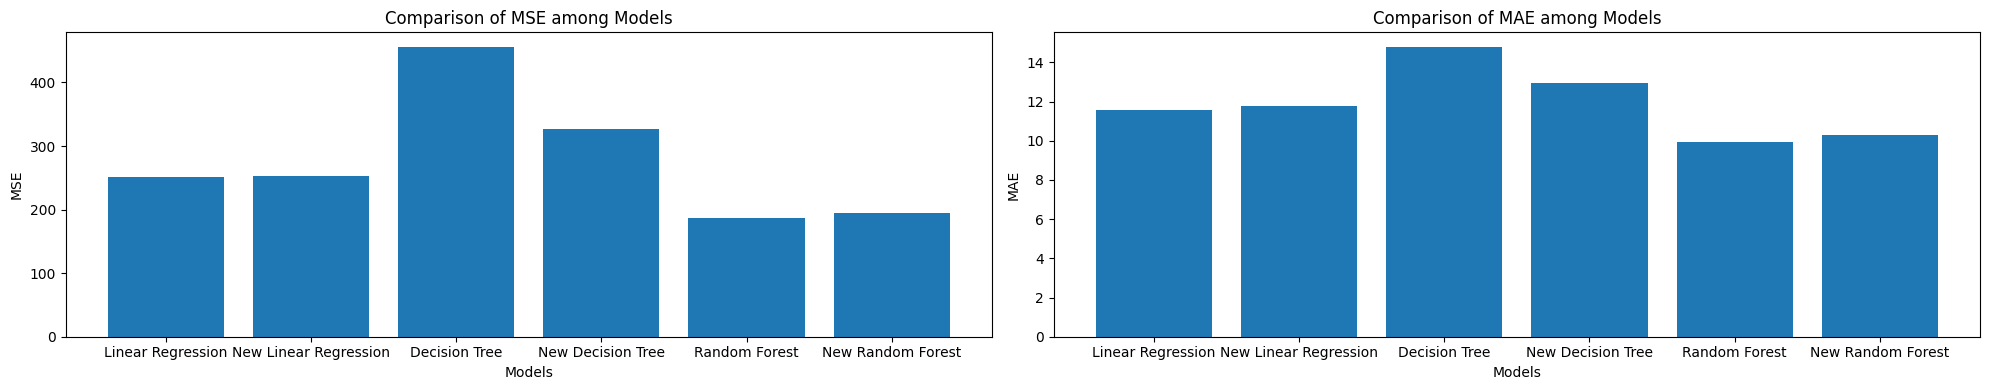

In [16]:
# Plot the compare results
import matplotlib.pyplot as plt

models = ['Linear Regression', 'New Linear Regression', 'Decision Tree', 'New Decision Tree', 'Random Forest', 'New Random Forest']
mse_values = [linear_mse, linear_mse_new, tree_mse, tree_mse_new, forest_mse, forest_mse_new]
mae_values = [linear_mae, linear_mae_new, tree_mae, tree_mae_new, forest_mae, forest_mae_new]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axes[0].bar(models, mse_values)
axes[0].set_title('Comparison of MSE among Models')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('MSE')

axes[1].bar(models, mae_values)
axes[1].set_title('Comparison of MAE among Models')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MAE')

plt.tight_layout()
plt.show()